# Part 0: Requirements

In [1]:
# Allow python to import modules from src folders
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
import ast
from collections import Counter
sys.path.append("src/")

from preprocessing.load_dataset import *

SAVE_PATH = "./data/refined"
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

## Download data  
Please uncomment the following line to download data

In [2]:
# %run src/preprocessing/download_dataset.py

# Part I: Load, explore and join datasets

## CMU dataset

We load the 4 `.tsv` and `.txt` files of the CMU dataset into 4 different dataframes

In [3]:
characters_df = load_characters_df()
movies_df = load_movies_df()
plot_df = load_plot_df()
tvtropes_df = load_tvtropes_df()

### Characters

The characters dataframe comes from the CMU movies dataset. This dataframe describes movie characters and provides information about the actor who played the corresponding character. Here is a sample of this dataframe :

In [4]:
characters_df.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
200572,4015188,/m/0bcm5s,1937,Manuel Fidello,1900-04-05,M,1.78,/m/033tf_,Spencer Tracy,36.0,/m/0jw2bp,/m/02nwc9k,/m/0cf2h
338967,34414683,/m/09rmlw7,1936-07-10,NaN,1908-08-13,M,1.82,NaN,Gene Raymond,27.0,/m/09vrwkt,NaN,/m/09rz1r
393411,5672353,/m/0dzdbl,1972-11,NaN,1939-10-17,M,NaN,NaN,Shin Kishida,NaN,/m/0gc9mrh,NaN,/m/03ccs9p
256927,32924345,/m/05h6t02,1941,NaN,1908-01-26,M,NaN,NaN,Dennis Moore,32.0,/m/0gm2m2k,NaN,/m/03hkx56
174378,1475914,/m/054hl9,2002,NaN,NaN,NaN,NaN,NaN,Chilton Crane,NaN,/m/0csh9d1,NaN,/m/0jt437


In [5]:
total_characters = len(characters_df)
print(f"Number of characters loaded: {total_characters}")
print(f"Number of unique movies: {len(characters_df['wiki_movie_id'].unique())}")
print(f"Number of unique actors: {len(characters_df['freebase_actor_id'].unique())}", end="\n\n")

print(f"Percentage of missing gender: {characters_df['actor_gender'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing height: {characters_df['actor_height'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing ethnicity: {characters_df['actor_ethnicity'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing age upon release: {characters_df['release_actor_age'].isna().sum()/total_characters*100:.2f}%", end="\n\n")

print(f"Number of character records for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()])}")
print(f"Number of unique actors for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()]['freebase_actor_id'].unique())}")

Number of characters loaded: 450669
Number of unique movies: 64330
Number of unique actors: 135761

Percentage of missing gender: 10.12%
Percentage of missing height: 65.65%
Percentage of missing ethnicity: 76.47%
Percentage of missing age upon release: 35.08%

Number of character records for which ethnicity is known: 106058
Number of unique actors for which ethnicity is known: 8151


We can first notice that a great percentage of actor's ethnicity is missing. This may become a problem when we study the impact of actors' ethnicity on the success of a movie. Let's investigate a bit.

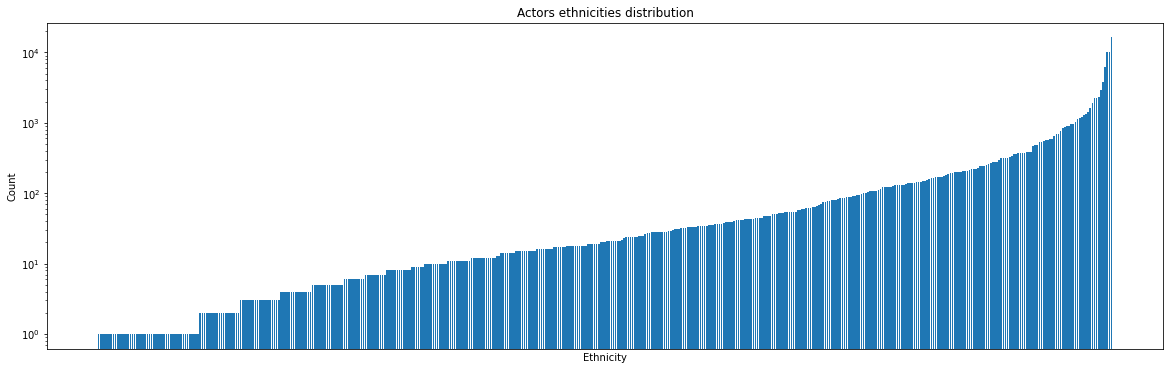

In [6]:
actors_ethnicities = characters_df[['freebase_actor_id', 'actor_ethnicity']].dropna().groupby(by='actor_ethnicity').count()
actors_ethnicities = actors_ethnicities.sort_values(by='freebase_actor_id')

plt.figure(figsize=(20,6))
plt.bar(actors_ethnicities.index, actors_ethnicities['freebase_actor_id'], label='')
plt.title("Actors ethnicities distribution")
plt.yscale('log')
plt.xticks([])
plt.ylabel("Count")
plt.xlabel("Ethnicity")
plt.show()

As shown, the ethnicities distribution is very heterogeneous. Some ethnicities have only one representative whereas others have more than thousands elements. During analysis, we must be careful on our conclusions as variance gets higher for the ethnicities with fewer representatives. Fortunately, we can quantify uncertainty in our results using tools like p-value and confidence interval.

### Movies

The movies dataframe also comes from the CMU dataset and provides information about movies such as its origins, runtime and box office.

In [7]:
movies_df.sample(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres
16993,31423579,/m/0crygj_,Big Boy Rides Again,1935,NaN,57.0,{},{'/m/09c7w0': 'United States of America'},"{'/m/03btsm8': 'Action/Adventure', '/m/01jfsb'..."
21711,8888296,/m/027ndgm,Season,1989,NaN,NaN,{'/m/0999q': 'Malayalam Language'},{'/m/03rk0': 'India'},"{'/m/0lsxr': 'Crime Fiction', '/m/01jfsb': 'Th..."
58756,2096585,/m/06lx4x,The Adventures of Mark Twain,1944-07-22,NaN,130.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/03bxz7': 'Biographical film', '/m/01g6gs'..."
47917,28375513,/m/0crghd4,180,2011-06-10,NaN,NaN,"{'/m/09s02': 'Telugu language', '/m/07c9s': 'T...",{},"{'/m/02l7c8': 'Romance Film', '/m/07s9rl0': 'D..."
26637,32842508,/m/09s3p8g,Park Avenue Logger,1937,NaN,65.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/03btsm8': 'Action/Adventure', '/m/0lsxr':..."


In [8]:
total_movies = len(movies_df)
print(f"Number of movies loaded: {total_movies}")
print(f"Percentage of missing box office revenue: {movies_df['box_office'].isna().sum()/total_movies*100:.2f}%")
print(f"Number of movies for which we have matching character data: {len(movies_df.merge(characters_df, how='inner', on=['wiki_movie_id', 'freebase_movie_id'])['freebase_movie_id'].unique())}")

Number of movies loaded: 81741
Percentage of missing box office revenue: 89.72%
Number of movies for which we have matching character data: 64330


A great proportion of box office revenue data is missing (almost 90%). This makes sense as lots of movies are not shown in cinemas such as TV movies, short movies. Indeed, to get a movie to the box office, one needs to work with studios or convince distributors to distribute the movie.

Thus, using box office as a way to measure a movie's performance may be biased because we already filter a specific type of movie. Furthermore, box office does not necessarily reflect the quality of a movie. Indeed some movies may not get a high box office revenue because of a lack of advertising. To fix this issue, we will use users rating from the IMDb database.

In [9]:
# Extract years from the release date of movies
movies_df['movie_release_year'] = movies_df[~movies_df['movie_release_date'].isna()]['movie_release_date'].astype(str).str[:4].astype(int)

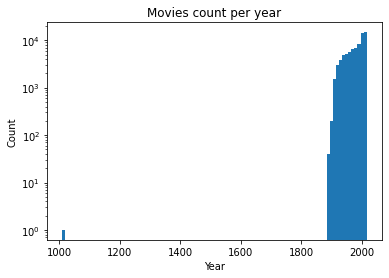

In [10]:
plt.hist(movies_df['movie_release_year'], bins=100)
plt.yscale("log")
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

We notice that a movie has been produced 700 years before the invention of potography ! Let's investigate:

In [11]:
wrong_dates = movies_df[movies_df['movie_release_year'] < 1800].index
movies_df.loc[wrong_dates]

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"{'/m/02hwyss': 'Turkish Language', '/m/02h40lc...",{'/m/01znc_': 'Turkey'},"{'/m/0lsxr': 'Crime Fiction', '/m/02n4kr': 'My...",1010.0


By googling the movie's name, we find that `Hunting season` should be released in 2010 (instead of 1010). This is obviously a typo and 1010 should be replaced by 2010.

In [12]:
# A movie that has the release date 1010. We fix the typo to 2010
movies_df.loc[wrong_dates, 'movie_release_year']= 2010
movies_df.loc[wrong_dates, 'movie_release_date'] ='2010-12-02'

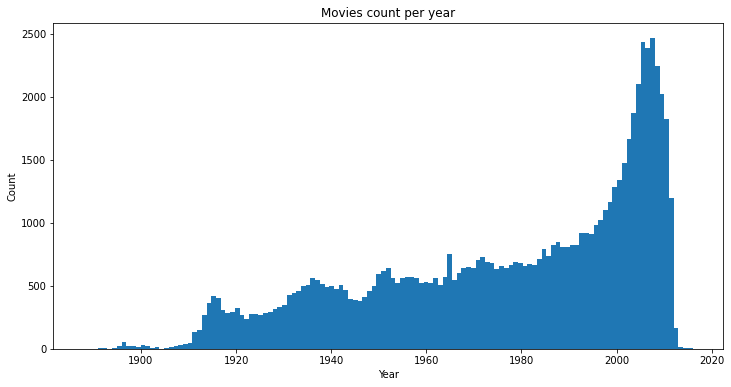

In [13]:
n_years = len(movies_df['movie_release_year'].dropna().unique())

plt.figure(figsize=(12, 6))
plt.hist(movies_df['movie_release_year'], bins=n_years)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

There are significantly more movies released after 1990 than before in our dataset.

### Plot

The plot dataframe comes from the CMU dataset and provides a summary of the plot of a given movie.

In [14]:
plot_df.sample(5)

,wiki_movie_id,plot_summary
40302,981105,Terry Noonan returns to New York's Hell's Kit...
2039,25427344,Mitti is a film about Punjab's youth today and...
23783,14899728,Vinod is a son of a prostitute who sells him ...
34258,21479442,The film is part three of the tetralogy Homem ...
20951,190053,"Somewhere in the jungles of South Africa, a mu..."


In [15]:
total_plot = len(plot_df)
print(f"Number of plot summaries loaded: {total_plot}")

Number of plot summaries loaded: 42303


### Tropes

The tvtropes dataframe is the one used by the CMU researchers to validate their personas learning algorithm. Unfortunately, this dataset does not contain a lot of tvtropes and can not be used for our analysis. Thus we need other databases to get the persona of movie characters.

In [16]:
tvtropes_df.sample(5)

,trope_name,character_data
309,hitman_with_a_heart,"{'char': 'Julian Noble', 'movie': 'The Matador..."
474,tranquil_fury,"{'char': 'Driver', 'movie': 'Drive', 'id': '/m..."
391,psycho_for_hire,"{'char': 'Mortimer Brewster', 'movie': 'Arseni..."
358,master_swordsman,"{'char': 'He-Man', 'movie': 'Masters of the Un..."
330,klutz,"{'char': 'Mia Thermopolis', 'movie': 'The Prin..."


In [17]:
total_tropes = len(tvtropes_df)
print(f"Number of tropes loaded: {total_tropes}")

Number of tropes loaded: 501


## IMDB dataset

We load the 4 `.tsv` files of the IMDB dataset into 4 different dataframes

In [18]:
imdb_ratings_df = load_imdb_ratings()
imdb_title_df = load_imdb_title_basics()
imdb_principals_df = load_imdb_title_principals()
imdb_people_df = load_imdb_person_basics()

### Ratings

Let's explore the ratings dataframe.

In [19]:
imdb_ratings_df.sample(5)

,tconst,averageRating,numVotes
531042,tt11389168,8.2,11
528686,tt11348188,9.8,5
38240,tt0059398,5.6,393
939109,tt2498912,8.7,4430
564353,tt12037150,7.5,139


We have 1365868 movies for which we have a rating.


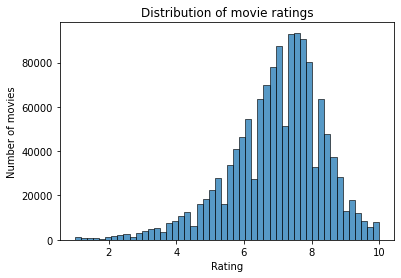

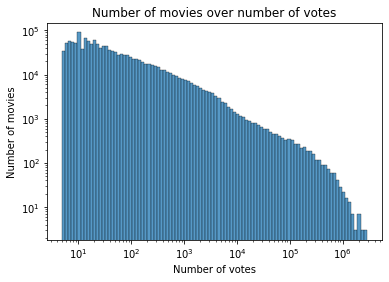

In [20]:
total_ratings = len(imdb_ratings_df)
print(f"We have {total_ratings} movies for which we have a rating.")

# Check the distribution of grades
sns.histplot(data=imdb_ratings_df, x="averageRating", bins=50)

plt.title("Distribution of movie ratings")
plt.xlabel("Rating")
plt.ylabel("Number of movies")
plt.show()

# Check the distribution of votes
sns.histplot(data=imdb_ratings_df, x="numVotes", bins=100, log_scale=True)
plt.yscale("log")

plt.title("Number of movies over number of votes")
plt.xlabel("Number of votes")
plt.ylabel("Number of movies")
plt.show()

### Title

In [21]:
imdb_title_df.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
4306733,tt16221908,movie,Dark Winter,Dark Winter,0,2021,\N,139,"Documentary,History,Horror"
8082699,tt5057402,movie,Yuki no tôge,Yuki no tôge,0,1924,\N,\N,Drama
8685969,tt6419372,movie,"Pura Vida, Bajo Los Cielos De Asia","Pura Vida, Bajo Los Cielos De Asia",0,2012,\N,\N,\N
228504,tt0238577,movie,Sawaal Majha Aika,Sawaal Majha Aika,0,1964,\N,\N,\N
234365,tt0244684,movie,No One Sleeps,No One Sleeps,0,2000,\N,108,"Drama,Mystery,Romance"


In [22]:
# Remove adult content
imdb_title_df = imdb_title_df[imdb_title_df["isAdult"].astype(int) == 0]

In [23]:
total_title = len(imdb_title_df)
print(f"We have {total_title} movie titles")

We have 651888 movie titles


### Principals

In [24]:
imdb_principals_df.sample(5)

,tconst,ordering,nconst,category,job,characters
46928981,tt5443162,1,nm5605726,director,\N,\N
9894922,tt1069566,9,nm2204601,writer,\N,\N
22505897,tt14916446,4,nm3015101,actor,\N,"[""Jean Buze de Aur""]"
14131001,tt11968008,5,nm9910648,self,\N,"[""Self""]"
43486265,tt3902736,7,nm6649407,writer,\N,\N


In [25]:
total_principals = len(imdb_principals_df)
print(f"We have {total_principals} principals records")
print(f"We have {len(imdb_principals_df['category'].unique())} categories")
print(f"We have {len(imdb_principals_df['nconst'].unique())} unique persons", end="\n\n")

# missing_characters = len(imdb_principals_df[imdb_principals_df['characters'] == "\\N"])
# print(f"We have {missing_characters/total_principals*100:.2f}% of missing characters")

We have 58900432 principals records
We have 12 categories
We have 5169350 unique persons



### People

In [26]:
imdb_people_df.sample(5)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
5681878,nm15125851,Power Maher,\N,\N,miscellaneous,tt3013774
7548061,nm3347060,Alexander D. Hemingway,\N,\N,editorial_department,"tt1753367,tt1326201,tt1556240,tt1627882"
4299552,nm13573964,Adrian Serban,\N,\N,art_department,tt0429573
5334161,nm14750969,Meisam Khanjan,\N,\N,set_decorator,tt8496186
7125663,nm2877917,Wei Shih,\N,\N,"make_up_department,production_manager","tt0122262,tt0201997,tt2173762,tt2173776"


In [27]:
total_people = len(imdb_people_df)
print(f"We have {total_people} people records")
print(f"We have {len(imdb_people_df['nconst'].unique())} unique persons")
print(f"We have {len(imdb_people_df[(imdb_people_df['primaryProfession'] == 'actor') | (imdb_people_df['primaryProfession'] == 'actress')])} unique actors")

We have 12978070 people records
We have 12978070 unique persons
We have 3862314 unique actors


### Movie titles with ratings

In [28]:
imdb_title_with_rating = imdb_title_df.merge(imdb_ratings_df, on='tconst', how='inner')
imdb_title_with_rating.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
13357,tt0035545,movie,Westward Ho!,Westward Ho!,0,1942,\N,56,"Drama,Western",6.7,34
109824,tt0314228,movie,Devil Returns,Jing hun feng yu ye,0,1982,\N,88,"Drama,Horror,Thriller",5.8,34
195074,tt1753945,movie,Il pozzo: Voci d'acqua dall'Etiopia,Il pozzo: Voci d'acqua dall'Etiopia,0,2013,\N,56,"Adventure,Documentary",7.1,10
230258,tt28768667,movie,Werewolves Unearthed,Werewolves Unearthed,0,2023,\N,\N,Documentary,5.2,6
19141,tt0043961,movie,The Red Badge of Courage,The Red Badge of Courage,0,1951,\N,69,"Drama,War",7.1,4763


In [29]:
total_movies_w_rating = len(imdb_title_with_rating)
print(f"We have {total_movies_w_rating} movies with ratings")

We have 294744 movies with ratings


There is more than one quarter of a million movies for which we have at least one rating. We have clearly much more data to work with than with box office revenue. Furthermore, there is a substantial amount of movies who have at least a few hundreds votes. This will allow us to get better confidence interval and reduce uncertainty in our analysis.

## Merge CMU movies and plot summaries with IMDB titles and ratings

The translation dataframe from wikidata, which includes both the IMDB id and the Freebase id, enables us to combine the IMDB dataset with the CMU dataset

In [30]:
translation_id = load_translation_df()

In [31]:
imdb_title_with_rating_translated = imdb_title_with_rating.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_title_with_rating_translated = imdb_title_with_rating_translated.drop(["imdb_id"], axis=1)

In [32]:
cmu_movies_w_imdb_rating = imdb_title_with_rating_translated.merge(movies_df, how='inner', left_on='freebase_id', right_on='freebase_movie_id').copy()

In [33]:
# Enriching CMU data
# IMDB start year has no missing data, so we insert it into "NaN" fields of "movie_release_date" and drop "startYear"
missing_years = cmu_movies_w_imdb_rating[cmu_movies_w_imdb_rating['movie_release_date'].isna()].index
cmu_movies_w_imdb_rating.loc[missing_years, 'movie_release_date'] = cmu_movies_w_imdb_rating.loc[missing_years, 'startYear']

In [34]:
# We have MANY depulicated attributes
# We evaluated for each pair which column had more missing data and dropped it in favor of the other
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop(["freebase_movie_id", "titleType", "isAdult", "endYear", "primaryTitle", "originalTitle", "movie_release_year", "movie_runtime", "startYear"], axis=1)

In [35]:
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop_duplicates("tconst")
print(f"The merged dataframe contains {len(cmu_movies_w_imdb_rating)} movies with corresponding ratings")

The merged dataframe contains 44467 movies with corresponding ratings


In [36]:
# Add summaries
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.merge(plot_df, on="wiki_movie_id", how="left")

In [37]:
cmu_movies_w_imdb_rating.sample(5)

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
26804,tt0126004,86,"Drama,Fantasy,Horror",6.0,2224,/m/04j0c3_,27874961,The Iron Rose,1973,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/03npn': 'Horror', '/m/09blyk': 'Psycholog...",A woman and man who met at a wedding reception...
18783,tt0081457,96,"Horror,Sci-Fi",4.3,1080,/m/080l1mt,24486281,Scared to Death,1981-03,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/07s9rl0': 'Drama', '/m/06n90': 'Science F...",A monster stalks Los Angeles as a Bio-Engineer...
40652,tt1245112,85,"Horror,Thriller",6.5,77224,/m/052_6hc,20753502,REC 2,2009-09-02,18469680.0,{'/m/06nm1': 'Spanish Language'},{'/m/06mkj': 'Spain'},"{'/m/01jfsb': 'Thriller', '/m/03npn': 'Horror'...","Dr. Owen , an official from the Ministry of He..."
29732,tt0202223,101,Drama,6.5,140,/m/027r4hf,8956466,El Amateur,1999-04-22,NaN,{'/m/06nm1': 'Spanish Language'},{'/m/0jgd': 'Argentina'},"{'/m/01z02hx': 'Sports', '/m/07s9rl0': 'Drama'...","On the outskirts of a provincial town, Pajaro ..."
18375,tt0079613,100,"Drama,Thriller",6.9,349,/m/09v5d4x,25743290,Natural Enemies,1981-10-15,NaN,{},{'/m/09c7w0': 'United States of America'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",NaN


`cmu_movies_w_imdb_rating` contains every informations that we need about a movie (such as its length, rating, genres, etc.) and will be used during our analysis. Next, we will focus on actors and  their respective personas.

## Merge IMDB people and principals
We now focus on characters and actors. We merge the two dataframes from IMDB and keep records of interest i.e for which the movie is in the collection above.

In [38]:
titles_of_interest = cmu_movies_w_imdb_rating["tconst"].to_list()

In [39]:
imdb_actors = imdb_people_df[(imdb_people_df["primaryProfession"].str.contains("actor")) | (imdb_people_df["primaryProfession"].str.contains("actoress"))].copy()

In [40]:
imdb_principals_actors = imdb_principals_df[(imdb_principals_df["category"] == "actress") | (imdb_principals_df["category"] == "actor")].copy()

In [41]:
imdb_actors_and_characters = imdb_actors.merge(imdb_principals_actors, on="nconst", how="inner").copy()

In [42]:
imdb_actors_and_characters = imdb_actors_and_characters[imdb_actors_and_characters["tconst"].isin(titles_of_interest)]

In [43]:
imdb_actors_and_characters = imdb_actors_and_characters.drop(["ordering", "category", "job", "primaryProfession"], axis=1)

In [44]:
imdb_actors_and_characters.sample(5)

,nconst,primaryName,birthYear,deathYear,knownForTitles,tconst,characters
1889853,nm0244707,André Dussollier,1946,\N,"tt0344510,tt0362225,tt0211915,tt2316801",tt1156143,"[""Georges Palet""]"
2850390,nm0417824,Leon Janney,1917,1980,"tt0021854,tt0221585,tt0062794,tt0022261",tt0023347,"[""Junior Barry""]"
4831087,nm0842536,Jan Swiderski,1916,1988,"tt0441074,tt0052036,tt0048243,tt0065908",tt0040012,"[""Ryszard""]"
262488,nm0007042,Herbert Lom,1917,2012,"tt0072081,tt0058586,tt0075066,tt0085407",tt0196077,"[""Ford""]"
2937591,nm0435726,Jean-Pierre Kalfon,1938,\N,"tt0299710,tt0092797,tt0187474,tt0088591",tt0062480,"[""Le chef du Front de Libération de la Seine e..."


## Filter CMU characters
We keep records of interest in the same fashion as done above

In [45]:
titles_of_interest_wiki = cmu_movies_w_imdb_rating["wiki_movie_id"].to_list()

In [46]:
characters_interest = characters_df[characters_df["wiki_movie_id"].isin(titles_of_interest_wiki)]

In [47]:
characters_interest.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
17010,30196675,/m/0djcm_m,2010,Robert,1963-02-04,M,NaN,NaN,Cheung Siu Fai,46.0,/m/0f12mvq,/m/0fpx9bc,/m/0279118
321021,5230818,/m/0d916c,2002-05-01,Neville,1959-05-29,M,1.83,NaN,Adrian Paul,42.0,/m/0cs2zvk,/m/0lfx0hp,/m/014_4y
322223,697113,/m/033m2w,1986-07-02,Female Wing Kong Guard,NaN,NaN,NaN,NaN,Lia Chang,NaN,/m/0gcp1jv,/m/0hch98d,/m/0gbygx3
412814,30050508,/m/04tlxl9,2006,Mr. Wong,1955-01-19,M,NaN,/m/01g7zj,Paul Rodríguez,50.0,/m/04tly5r,/m/0h2xdjk,/m/0766nn
314803,2102101,/m/06m815,1996-02-23,NaN,1950-02-04,F,NaN,/m/02w7gg,Linda Bassett,46.0,/m/0cs8gvf,NaN,/m/03hg59x


## Merge IMDB actors and characters with CMU characters
We merge IMDB character and actor data with the CMU data. We make use of the movie translation dataframe again and the actor translation dataframe. We assume that an actor only plays one role in a movie. This is not necessarily true as some actors may play many roles in the same movie, but we assume that those cases are sufficiently rare so that we can ignore them.

In [49]:
# Actor translation dataframe
actor_translation_df = load_actors_translation_df()
actor_translation_df = actor_translation_df.rename(columns={'imdb_id' : 'actor_imdb_id', 'freebase_id' : 'actor_freebase_id'})

In [51]:
imdb_actors_and_characters_translated = imdb_actors_and_characters.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_actors_and_characters_translated = imdb_actors_and_characters_translated.merge(actor_translation_df, how='inner', left_on='nconst', right_on='actor_imdb_id')
imdb_actors_and_characters_translated = imdb_actors_and_characters_translated.drop(["imdb_id", "actor_imdb_id"], axis=1)

In [53]:
# TODO, currently merging on movie id and actor name. Would rather merge with actor id too but a translation is needed
imdb_actors_w_cmu_characters = imdb_actors_and_characters_translated.merge(characters_interest, how='inner', left_on=['freebase_id', 'actor_freebase_id'], 
                                                                           right_on=['freebase_movie_id', 'freebase_actor_id']).copy()

# Merge birth year information
missing_birth_years = imdb_actors_w_cmu_characters[imdb_actors_w_cmu_characters['actor_birth'].isna()].index
imdb_actors_w_cmu_characters.loc[missing_birth_years, 'actor_birth'] = imdb_actors_w_cmu_characters.loc[missing_birth_years, 'birthYear']

imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop(["freebase_movie_id", "freebase_actor_id", "primaryName", "deathYear", "birthYear", "character_name"], axis=1)

imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop_duplicates()

imdb_actors_w_cmu_characters.sample(5)

,nconst,knownForTitles,tconst,characters,freebase_id,actor_freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id
56332,nm0620664,"tt0494767,tt0188640,tt1353147,tt0257885",tt0468820,"[""Ikeda - Tetsuzô's Friend""]",/m/0994bg,/m/0gb_s8v,3391405,2005,1957-09-21,M,NaN,NaN,Shiro Namiki,47.0,/m/0gb_s8s,NaN
55190,nm3887625,"tt1939659,tt1706593,tt1809398,tt1517260",tt1647483,"[""Zack""]",/m/0gjckpz,/m/0f13cn3,31196469,2010-06-13,1987-12-11,M,NaN,NaN,Alex Russell,22.0,/m/0f13cn8,/m/0j1xs9x
15874,nm0192490,"tt0071464,tt0137358,tt0035521,tt0053779",tt0052556,"[""Henri Tournier""]",/m/0gqr7t,/m/02q2y2l,6821816,1958,1908-07-12,M,NaN,NaN,Alain Cuny,49.0,/m/0b_8ylp,NaN
15161,nm0000608,"tt0118749,tt0076729,tt0082136,tt0117765",tt0239467,"[""Kage Mulligan""]",/m/0b6lds_,/m/0187y5,26137841,2001,1936-02-11,M,1.8,NaN,Burt Reynolds,64.0,/m/0ggd76d,/m/0h14h39
2397,nm0000024,"tt0045943,tt0071877,tt0117631,tt0082031",tt0059012,"[""Henry IV""]",/m/07jpg0,/m/016ggh,2507217,1965,1904-04-14,M,1.8,NaN,John Gielgud,60.0,/m/0jwcbv,NaN


## Summary of results for part I
We now have two main dataframes for further analysis. One containing everything related to movies and their ratings and the other containing everything related to actors, their features and characters they played in a given movie.

In [55]:
movies = cmu_movies_w_imdb_rating.copy()
actors_characters = imdb_actors_w_cmu_characters.copy()

In [56]:
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,Romance,5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"Documentary,News,Sport",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"Action,Adventure,Biography",6.0,854,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",NaN
4,tt0000679,120,"Adventure,Fantasy",5.1,68,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",NaN


In [57]:
actors_characters.head()

,nconst,knownForTitles,tconst,characters,freebase_id,actor_freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id
0,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0025164,"[""Guy Holden""]",/m/0glnm,/m/0h953,61169,1934,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/0k557x,/m/0h184w0
1,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0026942,"[""Huck Haines""]",/m/02x5h46,/m/0h953,12800555,1935-03-08,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/03l20gb,/m/0h184_z
2,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0027125,"[""Jerry Travers""]",/m/0gnjh,/m/0h953,61501,1935,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/0k77vk,/m/0h184_5
3,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0027630,"[""Bake Baker""]",/m/08d56_,/m/0h953,2926860,1936-02-20,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/0jybbh,/m/0h184vt
4,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0028333,"[""Lucky Garnett""]",/m/03pw28,/m/0h953,919005,1936,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/0k407p,/m/0h184vl


In [58]:
movies.to_json(os.path.join(SAVE_PATH, "movies.json"), orient='records')

In [59]:
actors_characters.to_json(os.path.join(SAVE_PATH, "characters.json"), orient='records')

# Part II: Personas

In [60]:
# Load results of part I
movies = pd.read_json(os.path.join(SAVE_PATH, "movies.json"))
actors_characters = pd.read_json(os.path.join(SAVE_PATH, "characters.json"))

## TVTropes personas
We now load the 500 personas records we extracted from TVTropes

In [61]:
tvtropes_personas = load_tv_tropes_personas_df()
tvtropes_personas.head()

,id,trope,actor,character,movie_name
0,/m/02wszk9,chanteuse,Kathleen Turner,Jessica Rabbit,Who Framed Roger Rabbit
1,/m/0k5wls,chanteuse,Cameron Diaz,Tina Carlyle,The Mask
2,/m/0k50tl,chanteuse,Michelle Pfeiffer,Susie Diamond,The Fabulous Baker Boys
3,/m/0k3j8v,chanteuse,Marilyn Monroe,Sugar Kane Kowalczyk,Some Like It Hot
4,/m/0jvlc4,chanteuse,Isabella Rossellini,Dorothy Vallens,Blue Velvet


### Analyse tropes per actor
Let's see if actors have diverse tropes

In [62]:
tvtropes_per_actor = tvtropes_personas[["actor", "trope"]].copy().groupby("actor").agg(list).reset_index()

In [63]:
tvtropes_per_actor["num_tropes"] = tvtropes_per_actor["trope"].apply(lambda ls: len(list(dict.fromkeys(ls))))

In [64]:
tvtropes_per_actor = tvtropes_per_actor.sort_values("num_tropes", ascending = False)

In [65]:
tvtropes_per_actor.head()

,actor,trope,num_tropes
166,Johnny Depp,"[casanova, charmer, byronic_hero, byronic_hero...",7
279,Robert De Niro,"[crazy_jealous_guy, crazy_jealous_guy, tranqui...",6
109,Harrison Ford,"[charmer, bounty_hunter, loveable_rogue, trick...",6
57,Clint Eastwood,"[retired_outlaw, heartbroken_badass, bounty_hu...",6
64,Daniel Craig,"[cultured_badass, heartbroken_badass, charmer,...",5


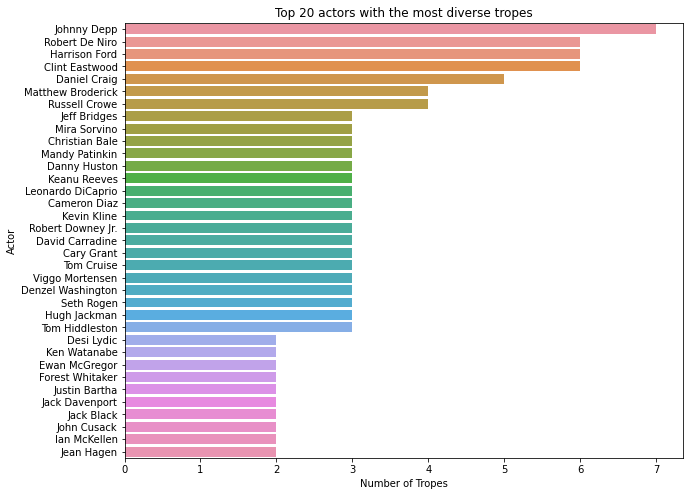

In [66]:
plt.figure(figsize=(10, 8))
sns.barplot(data = tvtropes_per_actor.head(35), x="num_tropes", y="actor", orient='h')
plt.xlabel('Number of Tropes')
plt.ylabel('Actor')
plt.title('Top 20 actors with the most diverse tropes')
plt.show()

As we can see we have a problem. We only have very few well known actors with multiple personas. This makes further analysis impossible with this dataset

### Analyse frequency of tropes when joined with our movies
This merging step is far from perfect as we have to merge on movie name, which is not a primary key. The generated data is widely unreliable, but we still plot it to get an idea of the distribution of personas.

In [67]:
tvtropes_personas_std = tvtropes_personas.copy()
tvtropes_personas_std['movie_name_standardized'] = tvtropes_personas_std['movie_name'].str.lower()

In [68]:
movies_std = movies.copy()
movies_std['movie_name_standardized'] = movies_std['movie_name'].str.lower()

In [69]:
movies_personas = movies_std.merge(tvtropes_personas_std, on='movie_name_standardized', how='inner')

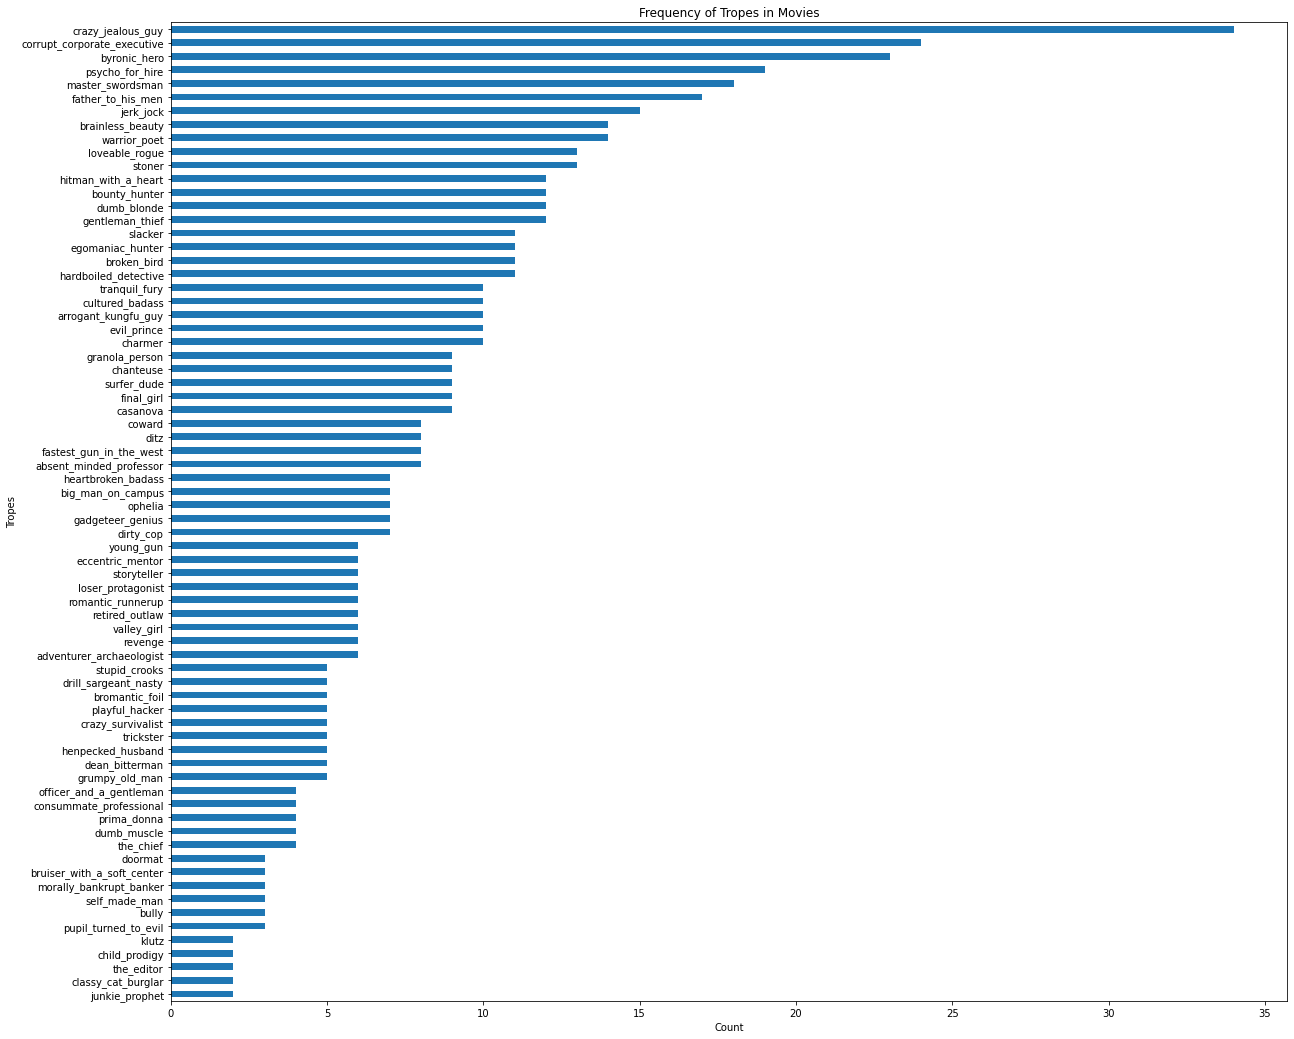

In [70]:
trope_value_counts = movies_personas['trope'].value_counts()

plt.figure(figsize=(20, 18))
trope_value_counts.plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Tropes')
plt.title('Frequency of Tropes in Movies')
plt.gca().invert_yaxis()
plt.show()

## CMU personas with characters
We merge the actors and characters information we extracted in part I with the personas from the original paper

In [71]:
cmu_personas = load_personas()

In [72]:
cmu_personas.sample(5)

,freebase_id,wiki_id,movie_name,secondary_name,full_name,token_occurences,estimated_trope,trope_distrib
168789,/m/062_92n,8619888,Next Avengers: Heroes of Tomorrow,Iron Man,Iron Man-style,3,29,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0,..."
13319,e14,12098160,Strange Bedfellows,they,the men he was not convinced in the interview,3,23,"[0.0, 0.0, 0.03, 0.0, 0.0, 0.01, 0.04, 0.0, 0...."
93093,e12,28195052,Tinker Bell: Secret of the Wings,Tink,Tink,11,1,"[0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
97389,e2,2920744,My Favourite Wife,Bianca,Bianca,4,49,"[0.0, 0.0, 0.02, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0..."
128527,e3,4109412,Sanctuary,Hojo,Akira Hojo,3,2,"[0.0, 0.01, 0.17, 0.16, 0.0, 0.01, 0.0, 0.0, 0..."


In [73]:
movies_personas_cmu = cmu_personas.merge(actors_characters, left_on='freebase_id', right_on='freebase_map_id')

In [74]:
movies_personas_cmu.sample(5)

,freebase_id_x,wiki_id,movie_name,secondary_name,full_name,token_occurences,estimated_trope,trope_distrib,nconst,knownForTitles,...,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id
413,/m/0k0jv3,1127093,Mean Creek,Marty,Marty,21,41,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nm1310709,"tt0356150,tt0482374,tt0377091,tt0438315",...,1127093,2004-01-15,1981-01-17,M,1.829,/m/041rx,Scott Mechlowicz,22.0,/m/0k0jv3,/m/0bjb9z9
121,/m/02vbmb0,10380700,Trick 'r Treat,Mr. Kreeg,Kreeg,18,21,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nm0004051,"tt0268126,tt0332452,tt7660850,tt0290334",...,10380700,2008,1946-06-01,M,1.760,/m/02g7sp,Brian Cox,61.0,/m/02vbmb0,/m/0h5kc7m
9194,/m/0k3nnq,820919,Spies Like Us,Austin Millbarge,Millbarge,4,34,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nm0000101,"tt0080455,tt0102558,tt0118747,tt0087332",...,820919,1985-12-06,1952-07-01,M,1.850,/m/0g8_vp,Dan Aykroyd,33.0,/m/0k3nnq,/m/0h16qqf
5095,/m/0jtj13,2852763,Anbe Sivam,Anbarasu,Anbarasu,3,42,"[0.0, 0.0, 0.01, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0...",nm0534856,"tt9263550,tt6148156,tt5310090,tt1187043",...,2852763,2003,1970-06-01,M,1.770,/m/0cmdl5l,R. Madhavan,32.0,/m/0jtj13,/m/0h2yqk0
7510,/m/0k6sgw,5275752,The Ultimate Gift,Jason Stevens,he,44,17,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nm0298221,"tt0859592,tt0310298,tt0158552,tt0482629",...,5275752,2006,1980-05-19,M,1.850,/m/07bch9,Drew Fuller,25.0,/m/0k6sgw,/m/0h5h9_d


In [75]:
print(f"We have {len(movies_personas_cmu)} records for characters")

We have 9927 records for characters


This offers us one possiblity for further analysis, as we have more than 10'000 records

## Movie-based comfort zones
We investigate the possiblity of coming up with comfort zones by analysing movie features for a given actor

In [76]:
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,Romance,5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"Documentary,News,Sport",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"Action,Adventure,Biography",6.0,854,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",None
4,tt0000679,120,"Adventure,Fantasy",5.1,68,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",None


In [77]:
actors_characters.head()

,nconst,knownForTitles,tconst,characters,freebase_id,actor_freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id
0,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0025164,"[""Guy Holden""]",/m/0glnm,/m/0h953,61169,1934,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/0k557x,/m/0h184w0
1,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0026942,"[""Huck Haines""]",/m/02x5h46,/m/0h953,12800555,1935-03-08,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/03l20gb,/m/0h184_z
2,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0027125,"[""Jerry Travers""]",/m/0gnjh,/m/0h953,61501,1935,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/0k77vk,/m/0h184_5
3,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0027630,"[""Bake Baker""]",/m/08d56_,/m/0h953,2926860,1936-02-20,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/0jybbh,/m/0h184vt
4,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0028333,"[""Lucky Garnett""]",/m/03pw28,/m/0h953,919005,1936,1899-05-10,M,1.75,/m/01qhm_,Fred Astaire,NaN,/m/0k407p,/m/0h184vl


In [78]:
all_data = movies.merge(actors_characters, how="inner", on=["tconst", "freebase_id", "wiki_movie_id"])

In [79]:
all_data.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,...,actor_freebase_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id
0,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,...,/m/0n5_12j,1907-06-20,\N,M,NaN,None,Henri Gouget,NaN,/m/0n5_12f,None
1,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,...,/m/0n5_11v,1907-06-20,1874-01-14,M,NaN,None,Georges Wague,NaN,/m/0n5_11r,None
2,tt0002199,60,"Biography,Drama",5.8,621,/m/0jr0h,73497,From the Manger to the Cross,1912-10-03,NaN,...,/m/07ps7s,1912-10-03,1882-08-05,M,NaN,None,Robert G. Vignola,NaN,/m/09z7jx_,/m/075q20p
3,tt0002461,55,Drama,5.7,305,/m/02vrnr1,12156493,Richard III,1912-10-15,NaN,...,/m/07ns8v,1912-10-15,1851-02-23,M,NaN,None,Frederick Warde,NaN,/m/0ggf7fc,None
4,tt0002574,150,"Action,Drama,Thriller",6.1,33,/m/07yh1s,2695568,What Happened to Mary?,1912-07-26,NaN,...,/m/07yhvx,1912-07-26,1865-06-05,M,NaN,None,Charles Stanton Ogle,NaN,/m/0lcyswt,/m/0lcyswy


In [80]:
all_data.columns

Index(['tconst', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes',
       'freebase_id', 'wiki_movie_id', 'movie_name', 'movie_release_date',
       'box_office', 'movie_languages', 'movie_countries', 'movie_genres',
       'plot_summary', 'nconst', 'knownForTitles', 'characters',
       'actor_freebase_id', 'release_date', 'actor_birth', 'actor_gender',
       'actor_height', 'actor_ethnicity', 'actor_name', 'release_actor_age',
       'freebase_map_id', 'freebase_character_id'],
      dtype='object')

### Based on movie genre

In [81]:
movie_genre_per_actor = all_data[["nconst", "actor_name", "movie_genres"]].copy()

In [82]:
movie_genre_per_actor["genres_flattened"] = movie_genre_per_actor["movie_genres"].apply(lambda genres: list(genres.values()))

In [83]:
movie_genre_per_actor = movie_genre_per_actor.drop("movie_genres", axis=1)

In [84]:
movie_genre_per_actor = movie_genre_per_actor.groupby(["nconst", "actor_name"]).agg(list).reset_index()

In [85]:
movie_genre_per_actor["total_movies"] = movie_genre_per_actor["genres_flattened"].apply(len)

In [86]:
movie_genre_per_actor["genres_flattened"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: [item for row in ls for item in row])

In [87]:
movie_genre_per_actor["genres_freq"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: dict(sorted(dict(Counter(ls)).items(), key=lambda item: item[1], reverse=True)))

In [88]:
movie_genre_per_actor = movie_genre_per_actor.drop("genres_flattened", axis=1)

In [89]:
movie_genre_per_actor.head()

,nconst,actor_name,total_movies,genres_freq
0,nm0000001,Fred Astaire,33,"{'Musical': 28, 'Comedy': 20, 'Romance Film': ..."
1,nm0000007,Humphrey Bogart,68,"{'Drama': 52, 'Black-and-white': 41, 'Crime Fi..."
2,nm0000009,Richard Burton,48,"{'Drama': 37, 'Romance Film': 15, 'War film': ..."
3,nm0000011,Gary Cooper,73,"{'Drama': 40, 'Black-and-white': 38, 'Romance ..."
4,nm0000015,James Dean,3,"{'Drama': 3, 'Family Drama': 2, 'Film adaptati..."


#### Distribution of some actors

In [90]:
top_actors = movie_genre_per_actor.sort_values("total_movies", ascending=False).copy().head()

In [91]:
actor_1 = top_actors["genres_freq"].iloc[0]

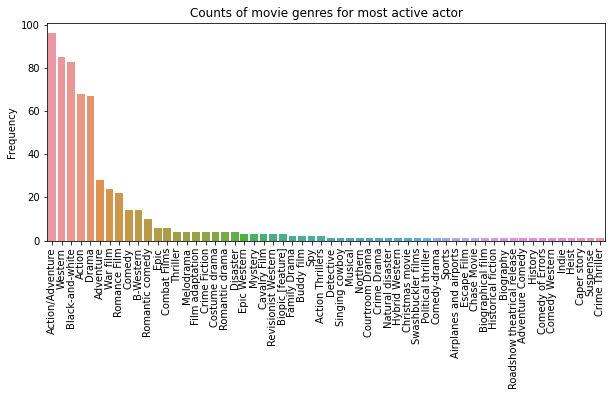

In [92]:
plt.figure(figsize=(10, 4))
plt.title('Counts of movie genres for most active actor')
sns.barplot(x=list(actor_1.keys()), y=list(actor_1.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [93]:
actor_2 = top_actors["genres_freq"].iloc[1]

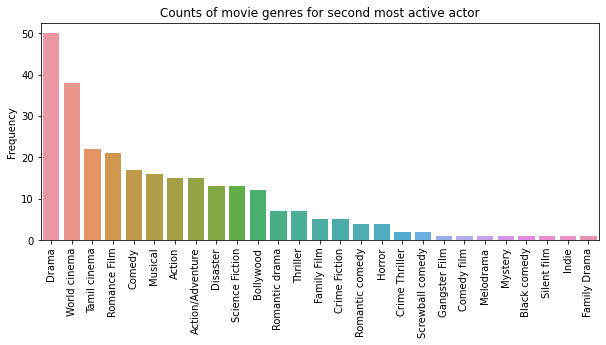

In [94]:
plt.figure(figsize=(10, 4))
plt.title('Counts of movie genres for second most active actor')
sns.barplot(x=list(actor_2.keys()), y=list(actor_2.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

### Based on runtime minutes

In [95]:
runtime_per_actor = all_data[["nconst", "actor_name", "runtimeMinutes"]].copy()

In [96]:
runtime_per_actor = runtime_per_actor[runtime_per_actor["runtimeMinutes"] != "\\N"]

In [97]:
runtime_per_actor = runtime_per_actor.groupby(["nconst", "actor_name"]).agg(list).reset_index()

In [98]:
runtime_per_actor["runtimeMinutes"] = runtime_per_actor["runtimeMinutes"].apply(lambda ls: list(map(lambda elem: int(elem), ls)))

In [99]:
runtime_per_actor['len'] = runtime_per_actor['runtimeMinutes'].apply(len)
runtime_per_actor = runtime_per_actor.sort_values(by='len', ascending=False).drop(columns='len')

#### Distribution of some actors

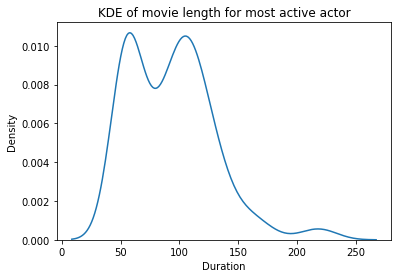

In [100]:
plt.title('KDE of movie length for most active actor')
sns.kdeplot(runtime_per_actor["runtimeMinutes"].iloc[0])
plt.ylabel("Density")
plt.xlabel("Duration")
plt.show()

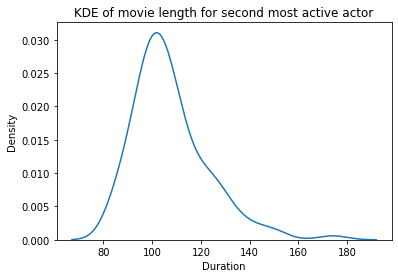

In [101]:
plt.title('KDE of movie length for second most active actor')
sns.kdeplot(runtime_per_actor["runtimeMinutes"].iloc[1])
plt.ylabel("Density")
plt.xlabel("Duration")
plt.show()